In [4]:
import easyocr
reader = easyocr.Reader(['en'])
result = reader.readtext('cnic.jpeg')
for (bbox, text, prob) in result:
    print(text)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


PAKISTAN
National Identity Card
ISLAMIC REPUBLIC OF PAKISTAN
Name
Muhammad Mudassir Zaman
Ulii_}
Father Name
Shafqat Zaman
Gender
Country of Stay
M
Pakistan
Identity Number
Date of Birth
42201-2908700-1
16.04.2001
Date of Issue
Date of Expiry
20.06.2019
20.06.2029
Holder
5
Signature
Uljez


In [9]:
import cv2
import easyocr
import face_recognition
import os
import numpy as np
import re
import matplotlib.pyplot as plt

CNIC_IMAGE = "cnic.jpeg"
KNOWN_DIR = "known_faces/dataset_imgs/"

# ============ STEP 1: OCR ============
print("🔍 Extracting text from CNIC...")

reader = easyocr.Reader(['en'])
ocr_results = reader.readtext(CNIC_IMAGE)

full_text = " ".join([text for (_, text, _) in ocr_results])
print("📝 OCR TEXT:", full_text)

# Extract CNIC Number using regex
cnic_match = re.findall(r"\d{5}-\d{7}-\d", full_text)
cnic_number = cnic_match[0] if cnic_match else "Not Found"

print("🆔 CNIC Number:", cnic_number)

# ============ STEP 2: FACE EXTRACTION ============
print("🙂 Extracting face from CNIC...")

cnic_img = face_recognition.load_image_file(CNIC_IMAGE)
face_locations = face_recognition.face_locations(cnic_img)

if len(face_locations) == 0:
    print("❌ No face found on CNIC")
    exit()

top, right, bottom, left = face_locations[0]
cnic_face = cnic_img[top:bottom, left:right]

cnic_encoding = face_recognition.face_encodings(cnic_img, face_locations)[0]

# ============ STEP 3: LOAD KNOWN DATASET ============
print("📂 Loading known faces...")

known_encodings = []
known_names = []

for file in os.listdir(KNOWN_DIR):
    path = os.path.join(KNOWN_DIR, file)
    image = face_recognition.load_image_file(path)
    encodings = face_recognition.face_encodings(image)
    
    if len(encodings) > 0:
        known_encodings.append(encodings[0])
        known_names.append(file)

print(f"✅ Loaded {len(known_names)} known faces")

# ============ STEP 4: FACE MATCH ============
print("🧠 Matching face...")

matches = face_recognition.compare_faces(known_encodings, cnic_encoding, tolerance=0.5)
distances = face_recognition.face_distance(known_encodings, cnic_encoding)

best_match = np.argmin(distances)

if matches[best_match]:
    print("✅ MATCH FOUND:", known_names[best_match])
    print("📏 Similarity Score:", distances[best_match])
else:
    print("❌ No match found")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


🔍 Extracting text from CNIC...
📝 OCR TEXT: PAKISTAN National Identity Card ISLAMIC REPUBLIC OF PAKISTAN Name Muhammad Mudassir Zaman Ulii_} Father Name Shafqat Zaman Gender Country of Stay M Pakistan Identity Number Date of Birth 42201-2908700-1 16.04.2001 Date of Issue Date of Expiry 20.06.2019 20.06.2029 Holder 5 Signature Uljez
🆔 CNIC Number: 42201-2908700-1
🙂 Extracting face from CNIC...
📂 Loading known faces...
✅ Loaded 402 known faces
🧠 Matching face...
✅ MATCH FOUND: me.jpeg
📏 Similarity Score: 0.4840879194092022


In [15]:
import concurrent.futures
import os
import pickle
import face_recognition

ENCODING_FILE = "encodings_hog/encodings.pkl"
KNOWN_DIR = "known_faces/dataset_imgs"


def encode_image(file):
    try:
        path = os.path.join(KNOWN_DIR, file)
        print(f"📸 Loading image: {path}")

        # load the image as RGB array
        img = face_recognition.load_image_file(path)

        # Extract face encodings
        enc = face_recognition.face_encodings(img)

        print(f"🔍 Faces found in {file}: {len(enc)}")

        # Accept only single-face images
        if len(enc) == 1:
            print(f"✅ Encoded: {file}")
            return enc[0], os.path.splitext(file)[0]
        else:
            print(f"⚠️ Skipped (not exactly 1 face): {file}")
            return None

    except Exception as e:
        print(f"❌ Error processing {file}: {e}")
        return None


def load_known_faces():
    known_faces, known_names = [], []

    # Load existing encodings if available
    if os.path.exists(ENCODING_FILE):
        print("📦 Loading existing encodings from PKL...")
        with open(ENCODING_FILE, "rb") as f:
            known_faces, known_names = pickle.load(f)

        print(f"✅ Loaded {len(known_faces)} known faces from file")

    existing = set(known_names)

    # Load dataset images
    files = [f for f in os.listdir(KNOWN_DIR) if f.lower().endswith((".jpg",".png",".jpeg"))]
    print(f"🖼️ Found {len(files)} images in dataset folder")

    new_count = 0
    skip_count = 0

    for file in files:
        name = os.path.splitext(file)[0]

        # Skip already encoded users
        if name in existing:
            print(f"⏭️ Already exists, skipping: {file}")
            skip_count += 1
            continue

        res = encode_image(file)
        if res:
            known_faces.append(res[0])
            known_names.append(res[1])
            new_count += 1

    # Save updated encodings
    print("💾 Saving encodings to PKL file...")
    with open(ENCODING_FILE, "wb") as f:
        pickle.dump((known_faces, known_names), f)

    print("\n================ SUMMARY ================")
    print(f"➕ New faces added: {new_count}")
    print(f"⏭️ Skipped existing: {skip_count}")
    print(f"📊 Total stored faces: {len(known_faces)}")
    print("========================================\n")

    return known_faces, known_names


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


📦 Loading existing encodings from PKL...
✅ Loaded 402 known faces from file
🖼️ Found 414 images in dataset folder
⏭️ Already exists, skipping: 100_10.jpg
⏭️ Already exists, skipping: 101_11.jpg
⏭️ Already exists, skipping: 102_11.jpg
⏭️ Already exists, skipping: 103_11.jpg
⏭️ Already exists, skipping: 104_11.jpg
⏭️ Already exists, skipping: 105_11.jpg
⏭️ Already exists, skipping: 106_11.jpg
⏭️ Already exists, skipping: 107_11.jpg
⏭️ Already exists, skipping: 108_11.jpg
⏭️ Already exists, skipping: 109_11.jpg
⏭️ Already exists, skipping: 10_1.jpg
⏭️ Already exists, skipping: 110_11.jpg
⏭️ Already exists, skipping: 111_12.jpg
⏭️ Already exists, skipping: 112_12.jpg
⏭️ Already exists, skipping: 113_12.jpg
⏭️ Already exists, skipping: 114_12.jpg
⏭️ Already exists, skipping: 115_12.jpg
⏭️ Already exists, skipping: 116_12.jpg
⏭️ Already exists, skipping: 117_12.jpg
⏭️ Already exists, skipping: 118_12.jpg
⏭️ Already exists, skipping: 119_12.jpg
⏭️ Already exists, skipping: 11_2.jpg
⏭️ Already

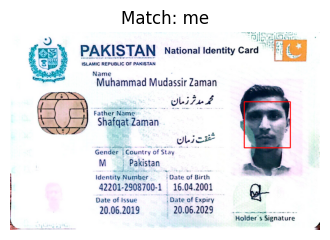

{
  "status": "matched",
  "cnic_number": "42201-2908700-1",
  "person": "me",
  "confidence": 0.516,
  "time_taken_sec": 14.416
}


In [23]:
import easyocr
import re
import sys
import time 
import json 

def recognize_face(input_image_file):
    start_time = time.time()

    # ================= LOAD KNOWN FACES =================
    known_faces, known_names = load_known_faces()
    if not known_faces:
        return {"status": "no_known_faces"}

    # ================= LOAD CNIC IMAGE =================
    input_image = face_recognition.load_image_file(input_image_file)

    # ================= OCR CNIC TEXT =================
    print("🔍 Running EasyOCR on CNIC...")
    reader = easyocr.Reader(['en'])
    ocr_results = reader.readtext(input_image_file)

    full_text = " ".join([text for (_, text, _) in ocr_results])
    print("📝 OCR TEXT:", full_text)

    # Extract CNIC Number
    cnic_match = re.findall(r"\d{5}-\d{7}-\d", full_text)
    cnic_number = cnic_match[0] if cnic_match else "Not Found"

    print("🆔 CNIC Number:", cnic_number)

    # ================= FACE DETECTION =================
    face_locations = face_recognition.face_locations(input_image, model="hog")
    if not face_locations:
        return {"status": "no_face_detected", "cnic_number": cnic_number}

    # ================= FACE ENCODING =================
    input_encodings = face_recognition.face_encodings(input_image, known_face_locations=face_locations)
    if not input_encodings:
        return {"status": "encoding_failed", "cnic_number": cnic_number}

    # ================= MATCHING =================
    matched_person = None
    matched_confidence = None

    known_faces_np = np.array(known_faces)

    for input_encoding in input_encodings:
        distances = np.linalg.norm(known_faces_np - input_encoding, axis=1)
        best_match_index = distances.argmin()
        best_distance = distances[best_match_index]

        if best_distance < 0.50:
            matched_person = known_names[best_match_index]
            matched_confidence = round(1 - best_distance, 3)
            break

    # ================= DRAW FACE BOX =================
    display_image = input_image.copy()

    for (top, right, bottom, left) in face_locations:
        cv2.rectangle(display_image, (left, top), (right, bottom), (255, 0, 0), 4)

    # ================= SHOW RESULT =================
    plt.figure(figsize=(4,4))
    plt.imshow(display_image)
    plt.axis('off')
    plt.title(f"Match: {matched_person if matched_person else 'Unknown'}")
    plt.show()

    # ================= RETURN RESULT =================
    if matched_person:
        return {
            "status": "matched",
            "cnic_number": cnic_number,
            "person": matched_person,
            "confidence": matched_confidence,
            "time_taken_sec": round(time.time() - start_time, 3)
        }

    return {
        "status": "not_matched",
        "cnic_number": cnic_number,
        "time_taken_sec": round(time.time() - start_time, 3)
    }

if __name__ == "__main__":
    if len(sys.argv) > 1:
        image_path = sys.argv[1]
        result = recognize_face("cnic.jpeg")
        print(json.dumps(result, indent=2))
    else:
        print("Usage: python script.py <image_path>")